In [1]:
%reset -f

In [2]:
import numpy as np
import torchdiffeq
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from typing import List

In [3]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [4]:
# --- build a simple rod: 3 DOF per node (x,y,z) ---
def create_rod_with_nodes(num_nodes: int):
    nodes = []
    for i in range(num_nodes):
        nodes.append(np.array([i * 0.1, 0.0, 0.0], dtype=np.float32))
    return nodes
num_nodes = 11
nodes = create_rod_with_nodes(num_nodes)  # 11 nodes -> ndof = 33
q0 = np.array(nodes, dtype=np.float32).reshape(-1)         # positions (ndof,)
v0 = np.zeros_like(q0, dtype=np.float32)                   # velocities (ndof,)

x0 = torch.tensor(np.concatenate([q0, v0]), dtype=torch.float32)  # (2*ndof,)

print("Initial positions q0:", q0)
print("Initial velocities v0:", v0)
print("Initial state x0:", x0)

# create springs (3 consecutive nodes and effective length)
stretch_springs = []
bend_springs = []
for i in range(0, num_nodes):
    if i == 0:
        # boundary nodes: leff = 0.05
        l0 = np.linalg.norm(np.array(nodes[i+1] - nodes[i]))
        stretch_springs.append((i, i + 1, -1))
    elif i == num_nodes - 1:
        # boundary nodes: leff = 0.05
        l0 = np.linalg.norm(np.array(nodes[i] - nodes[i-1]))
        stretch_springs.append((i - 1, i, -1))
    else:
        # internal nodes: leff = 0.1
        l0 = np.linalg.norm(np.array(nodes[i] - nodes[i-1]))
        l1 = np.linalg.norm(np.array(nodes[i+1] - nodes[i]))
        leff = 0.5 * (l0 + l1)
        stretch_springs.append((i - 1, i, i + 1))
        bend_springs.append((i - 1, i, i + 1))

# Material properties
E = 1e7  # Young's modulus
r0 = 0.01  # radius
A = np.pi * r0**2  # cross-sectional area
I = 0.25 * np.pi * r0**4  # area moment of inertia
rho = 1200  # density
mass = rho*A*1  # mass per segment (length 1 m)
m_per_node = mass/num_nodes

EA = E * A  # axial stiffness
EI = E * I  # bending stiffness
stiffness_matrix = torch.tensor([[EA, 0.0],
                                  [0.0, EI]], dtype=torch.float32)
stiffnesses = stiffness_matrix.to(device)

# print("Stretch springs:", stretch_springs)
# print("Bend springs:", bend_springs)
print(f"EA={EA:.3e}, EI={EI:.3e}")


Initial positions q0: [0.  0.  0.  0.1 0.  0.  0.2 0.  0.  0.3 0.  0.  0.4 0.  0.  0.5 0.  0.
 0.6 0.  0.  0.7 0.  0.  0.8 0.  0.  0.9 0.  0.  1.  0.  0. ]
Initial velocities v0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Initial state x0: tensor([0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000,
        0.3000, 0.0000, 0.0000, 0.4000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000,
        0.6000, 0.0000, 0.0000, 0.7000, 0.0000, 0.0000, 0.8000, 0.0000, 0.0000,
        0.9000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])
EA=3.142e+03, EI=7.854e-02


In [5]:
# from strains_torch import get_strain_stretch2D_torch, get_strain_curvature_3D_torch
from stretch_energy_torch import grad_and_hess_energy_stretch_linear_elastic_torch, get_energy_stretch_linear_elastic_torch, get_strain_stretch2D_torch
from bend_energy_torch import grad_and_hess_energy_bending_linear_elastic_torch, get_energy_bending_linear_elastic_torch, get_strain_curvature_3D_torch

In [6]:
class AnalyticalODE(nn.Module):
    def __init__(self, ndof: int, m_per_dof: float = 1.0, c_per_dof: float = 0.1, 
                 g: float = 9.81, freeDOF: List[int]=None, bend_springs: torch.Tensor = None, stretch_springs: torch.Tensor = None,
                 stiffnesses: torch.Tensor = None, dtype=torch.float32):
        super().__init__()
        self.ndof = ndof
        self.freeDOF = freeDOF
        self.call_count = 0

        # Indices / masks
        if freeDOF is None:
            freeDOF = list(range(ndof))
        free_idx = torch.as_tensor(freeDOF, dtype=torch.long)
        fixed_mask = torch.ones(ndof, dtype=torch.bool)
        fixed_mask[free_idx] = False
        self.register_buffer("free_idx", free_idx)
        self.register_buffer("fixed_mask", fixed_mask)
        self.register_buffer("free_mask", ~fixed_mask)  # same shape

        # Diagonal mass and damping for now (easy to replace with full matrices later)
        M = torch.eye(ndof) * m_per_dof       # (ndof, ndof)
        C = torch.eye(ndof) * c_per_dof       # (ndof, ndof)

        # Gravity as external force: acts in z only (every 3rd DOF starting from index 2)
        f_ext = torch.zeros(ndof)
        f_ext[2::3] = -m_per_dof * g          # (ndof,)
        # f_ext[0::3] = -m_per_dof * g          # (ndof,) # gravity in x-direction for testing

        # Register as buffers so dtype/device track the module (and no grads)
        self.register_buffer("M", M)
        self.register_buffer("C", C)
        self.register_buffer("f_ext", f_ext)

        # Pre-slice free blocks once (for diagonal M this is overkill but scales)
        self.register_buffer("M_ff", M.index_select(0, free_idx).index_select(1, free_idx))
        self.register_buffer("C_ff", C.index_select(0, free_idx).index_select(1, free_idx))

        # stencils
        self.register_buffer("bend_springs", bend_springs)
        self.register_buffer("stretch_springs", stretch_springs)

        # stiffnesses
        self.register_buffer("stiffnesses", stiffnesses)
        self.register_buffer("EA", stiffnesses[0,0])
        self.register_buffer("EI", stiffnesses[1,1])


    def elastic_bending_force(self, q: torch.Tensor) -> torch.Tensor:
        """
        q: (..., ndof)
        returns f_elastic: (..., ndof)
        """
        bend_springs = self.bend_springs.to(q.device)  # (n_springs, 3) with (i, j, k)
        f_bend = torch.zeros_like(q)
        l_eff = 0.1

        for spring in bend_springs:
            i, j, k = spring

            dof_indices = [
                3 * i, 3 * i + 1, 3 * i + 2,
                3 * j, 3 * j + 1, 3 * j + 2,
                3 * k, 3 * k + 1, 3 * k + 2,
            ]

            node0 = q[..., 3 * i:3 * i + 3]
            node1 = q[..., 3 * j:3 * j + 3]
            node2 = q[..., 3 * k:3 * k + 3]

            q_spring = torch.stack([node0, node1, node2], dim=-2)  # (..., 3, 3)
            q_spring = q_spring.clone().requires_grad_(True)

            node0_s = q_spring[..., 0, :]
            node1_s = q_spring[..., 1, :]
            node2_s = q_spring[..., 2, :]

            curvature = get_strain_curvature_3D_torch(
                node0_s, node1_s, node2_s
            )

            E_spring = 0.5 * self.EI/l_eff * curvature**2

            (dE_dq_spring,) = torch.autograd.grad(
                outputs=E_spring,
                inputs=q_spring,
                create_graph=True
            )   # (..., 3, 3)

            f_spring = -dE_dq_spring.reshape(*q.shape[:-1], 9)  # (..., 9)
            
            f_bend[..., dof_indices] += f_spring

        return f_bend

    def elastic_stretch_force(self, q: torch.Tensor) -> torch.Tensor:
        """
        q: (..., ndof)
        returns f_elastic: (..., ndof)
        """
        stretch_springs = self.bend_springs.to(q.device)  # (n_springs, 3) with (i, j, k)
        f_stretch = torch.zeros_like(q)
        l0 = 0.1
        l1 = 0.1
        for spring in stretch_springs:
            i, j, k = spring

            if k == -1:
                dof_indices = [
                    3 * i, 3 * i + 1, 3 * i + 2,
                    3 * j, 3 * j + 1, 3 * j + 2,
                ]
            else:
                dof_indices = [
                    3 * i, 3 * i + 1, 3 * i + 2,
                    3 * j, 3 * j + 1, 3 * j + 2,
                    3 * k, 3 * k + 1, 3 * k + 2,
                ]

            node0 = q[..., 3 * i:3 * i + 3]
            node1 = q[..., 3 * j:3 * j + 3]

            if k == -1:
                q_spring = torch.stack([node0, node1], dim=-2)  # (..., 3, 3)
            else:
                node2 = q[..., 3 * k:3 * k + 3]
                q_spring = torch.stack([node0, node1, node2], dim=-2)  # (..., 3, 3)
            
            q_spring = q_spring.clone().requires_grad_(True)

            node0_s = q_spring[..., 0, :]
            node1_s = q_spring[..., 1, :]

            # print("k: ", k)
            if k == -1:
                # boundary stretch spring (2 nodes only)
                l1 = 0.1  # dummy
                node2_s = None  # dummy
            else:
                l1 = 0.1
                node2_s = q_spring[..., 2, :]

            longitudinal_strain = get_strain_stretch2D_torch(
                node0_s, node1_s, node2_s, l0, l1
            )
            E_spring = 0.5 * self.EA * l1 * longitudinal_strain ** 2

            inputs = q_spring
            (dE_dq_spring,) = torch.autograd.grad(
                outputs=E_spring,
                inputs=inputs,
                create_graph=True,
                allow_unused=True
            )   # (..., 3, 3)

            if k==-1:
                f_spring = -dE_dq_spring.reshape(*q.shape[:-1], 6)  # (..., 6)
            else:
                f_spring = -dE_dq_spring.reshape(*q.shape[:-1], 9)  # (..., 9)
            
            f_stretch[..., dof_indices] += f_spring

        return f_stretch

    def elastic_force(self, q: torch.Tensor) -> torch.Tensor:
        f_stretch = self.elastic_stretch_force(q)
        f_bend = self.elastic_bending_force(q)
        f_elastic = f_stretch + f_bend
        return f_elastic
    
    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        x shape: (..., 2*ndof)
        Returns dx/dt with same shape.
        """
        ndof = self.ndof
        q = x[..., :ndof]        # (..., ndof)
        v = x[..., ndof:]        # (..., ndof)

        # Forces
        f_el = self.elastic_force(q)          # (..., ndof)
        f_damp = torch.matmul(v, self.C.T)    # (..., ndof)

        # External + elastic + damping
        rhs = -f_damp + f_el + self.f_ext     # (..., ndof)

        # Free-DOF solve
        idx = self.free_idx
        rhs_f = rhs.index_select(-1, idx)     # (..., n_free)
        v_f   = v.index_select(-1, idx)       # (..., n_free)

        M_ff = self.M_ff
        a_f = torch.linalg.solve(M_ff, rhs_f.unsqueeze(-1)).squeeze(-1)  # (..., n_free)

        # Scatter back to full
        a_full = torch.zeros_like(v)
        v_full = torch.zeros_like(v)
        a_full[..., idx] = a_f
        v_full[..., idx] = v_f

        dxdt = torch.cat([v_full, a_full], dim=-1)

        # Logging
        self.call_count += 1
        if self.call_count % 1000 == 0:
            ke = 0.5 * torch.sum(v_full**2)
            print(f"[{self.call_count}] t={t.item():.3f}, KE={ke.item():.3e}")

        return dxdt


In [7]:
# # --- set up and integrate ---
ndof = q0.size
freeDOF = list(range(6, ndof))  # fix first two nodes (first 6 DOF)
odefunc = AnalyticalODE(ndof=ndof,
                  m_per_dof=m_per_node,
                  c_per_dof=0.1,
                  g=9.81,
                  freeDOF=freeDOF,
                  bend_springs=torch.tensor(bend_springs, dtype=torch.int64), 
                  stretch_springs=torch.tensor(stretch_springs, dtype=torch.int64),
                  stiffnesses=torch.tensor(stiffnesses, dtype=torch.float32),
                  dtype=torch.float32).to(device)



/tmp/ipykernel_11339/2383993819.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stiffnesses=torch.tensor(stiffnesses, dtype=torch.float32),


In [8]:
dtype=torch.float32
# time discretization
T = 1
dt = 0.001
steps = int(T/dt) + 1
t = torch.linspace(0., T, steps, dtype=dtype)

# Now move all inputs / reference data
x0    = x0.to(device=device, dtype=dtype)
t     = t.to(device=device, dtype=dtype)
traj = odeint(odefunc, x0, t, method='rk4')   # (steps, 2*ndof)

[1000] t=0.250, KE=8.563e+00
[2000] t=0.500, KE=9.448e+00
[3000] t=0.750, KE=1.185e+00
[4000] t=1.000, KE=6.231e-01


In [9]:
print("Solution shape:", traj.shape)           # (T, 2*ndof)
q_traj = traj[:, :ndof]                        # (T, ndof)
v_traj = traj[:, ndof:]                        # (T, ndof)
print("q_traj[0]:", q_traj[0, :6])
print("v_traj[0]:", v_traj[0, :6])


Solution shape: torch.Size([1001, 66])
q_traj[0]: tensor([0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000], device='cuda:0',
       grad_fn=<SliceBackward0>)
v_traj[0]: tensor([0., 0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SliceBackward0>)


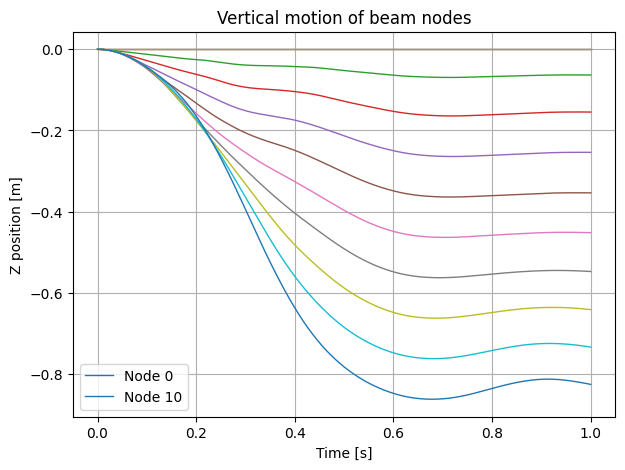

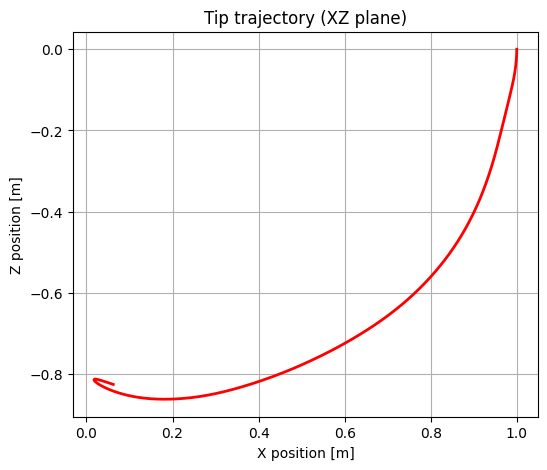

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert trajectory to numpy
q_traj_np = q_traj.detach().cpu().numpy().reshape(len(t), num_nodes, 3)
t_np = t.detach().cpu().numpy()

# Plot Z-displacement (vertical motion) of each node
plt.figure(figsize=(7, 5))
for i in range(num_nodes):
    plt.plot(t_np, q_traj_np[:, i, 2], label=f'Node {i}' if i in [0, num_nodes-1] else "", lw=1)
plt.xlabel("Time [s]")
plt.ylabel("Z position [m]")
plt.title("Vertical motion of beam nodes")
plt.legend()
plt.grid(True)
plt.show()

# Plot trajectory of beam tip (last node)
plt.figure(figsize=(6, 5))
plt.plot(q_traj_np[:, -1, 0], q_traj_np[:, -1, 2], 'r-', lw=2)
plt.xlabel("X position [m]")
plt.ylabel("Z position [m]")
plt.title("Tip trajectory (XZ plane)")
plt.grid(True)
plt.show()


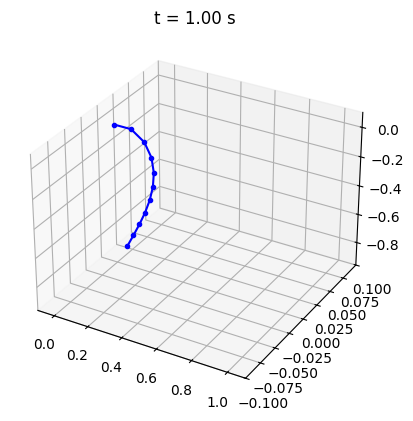

In [11]:
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.cla()
    ax.plot(q_traj_np[frame, :, 0],
            q_traj_np[frame, :, 1],
            q_traj_np[frame, :, 2],
            'b.-')
    ax.set_xlim([q_traj_np[:, :, 0].min()-0.1, q_traj_np[:, :, 0].max()+0.1])
    ax.set_ylim([q_traj_np[:, :, 1].min()-0.1, q_traj_np[:, :, 1].max()+0.1])
    ax.set_zlim([q_traj_np[:, :, 2].min()-0.1, q_traj_np[:, :, 2].max()+0.1])
    ax.set_title(f"t = {t[frame]:.2f} s")
    return ax

ani = animation.FuncAnimation(fig, update, frames=range(0, len(t), 10), interval=50)
ani.save("analytical_both_springs.gif", writer="ffmpeg", fps=20)
plt.show()
